In [1]:
!sudo sh -c 'echo 3 >/proc/sys/vm/drop_caches'

In [2]:
!free -m

             total       used       free     shared    buffers     cached
Mem:        100721      25641      75079          0          2        100
-/+ buffers/cache:      25539      75181
Swap:            0          0          0


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# import root_numpy
# import pandas

# data_k = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bu_JPsiK/Tracks.root', 
#                                                 selection='(e_cut == 1) || (mu_cut == 1) || (K_cut == 1)'))
# data_ks = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bd_JPsiKs//Tracks.root', 
#                                                  selection='(e_cut == 1) || (mu_cut == 1) || (K_cut == 1)'))

In [5]:
import root_numpy
import pandas

selection = '(ghostProb < 0.4) & ((PIDNNk > 0) | (PIDNNe > 0) | (PIDNNm > 0) | (PIDNNp > 0) | (PIDNNpi > 0))'
data_k = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bu_JPsiK/Tracks.root'))
data_ks = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bd_JPsiKstar/Tracks.root'))

In [6]:
len(data_k), len(data_ks)

(33656264, 9745851)

In [7]:
from utils import add_diff_pt

In [8]:
from itertools import combinations

def add_features(data, event_id_column='event_id'):
    event_id = data.run.apply(str) + '_' + data.event.apply(str)
    data['group_column'] = numpy.unique(event_id, return_inverse=True)[1]
    # all weights are 1, because this is MC
    data[event_id_column] = event_id
    
    add_diff_pt(data)
    # add cos(diff_phi)
    data.loc[:, 'cos_diff_phi'] = numpy.cos(data.diff_phi.values)
    PIDs = {'k': data.PIDNNk.values,
            'e': data.PIDNNe.values,
            'mu': data.PIDNNm.values,
           }
    for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
        data.loc[:, 'max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
        data.loc[:, 'sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2

In [9]:
add_features(data_k)
add_features(data_ks)

In [10]:
selection = '(ghostProb < 0.4) & ((PIDNNk > 0) | (PIDNNe > 0) | (PIDNNm > 0) | (PIDNNp > 0) | (PIDNNpi > 0))'
data_k = data_k.query(selection)
data_ks = data_ks.query(selection)

In [11]:
data = pandas.concat([data_k, data_ks])
data['label'] = [0] * len(data_k) + [1] * len(data_ks)

In [12]:
from folding_group import FoldingGroupClassifier
from rep.report.metrics import RocAuc
from rep.estimators import SklearnClassifier
from decisiontrain import DecisionTrainClassifier

In [13]:
features_ele = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'EOverP', 
                'ghostProb', 'log_IPPU: log(IPPU)']
features_muon = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'PIDNNm', 'ghostProb', 'log_IPPU: log(IPPU)']
features_kaon = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                 'nnkrec','log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 
                'PIDNNk', 'PIDNNpi', 'PIDNNp', 'ghostProb', 'log_IPPU: log(IPPU)']

In [14]:
features = ['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 
            'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm',
            'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 
            'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs']

In [15]:
selected_tt = dict()
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=500, depth=6,
                                  max_features=7, n_threads=12)
for mask, name, feat in zip([data.e_cut == 1,
                        data.mu_cut == 1, 
                        data.K_cut == 1, 
                        (data.mu_cut == 1) | (data.e_cut == 1) | (data.K_cut == 1)],
                       ['electron', 'muon', 'kaon', 'all particles'], 
                            [features_ele, features_muon, features_kaon, set.union(set(features_ele), 
                                                                                   set(features_muon),
                                                                                   set(features_kaon))]):
    selected_tt[name] = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                               train_features=feat, 
                                               group_feature='group_column')
    selected_tt[name].fit(data.ix[mask, :], data.loc[mask, 'label'])
    
    selected_tt[name + '/all features'] = FoldingGroupClassifier(SklearnClassifier(tt_base), 
                                                                 n_folds=2, random_state=11, 
                                                                   train_features=features, 
                                                                   group_feature='group_column')
    selected_tt[name + '/all features'].fit(data.ix[mask, :], data.loc[mask, 'label'])

In [16]:
data = data.ix[numpy.isfinite(data.IPs), :]

In [17]:
selected_tt['all tracks, inclusive tagging features'] = FoldingGroupClassifier(SklearnClassifier(tt_base), 
                                                                               n_folds=2, random_state=11, 
                                                                               train_features=features, 
                                                                               group_feature='group_column')
selected_tt['all tracks, inclusive tagging features'].fit(data, data.label)

FoldingGroupClassifier(base_estimator=SklearnClassifier(clf=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.1, loss=None, max_features=7, n_estimators=500,
            n_threads=12, train_features=None, update_step=4,
            use_friedman_mse=True),
         features=None),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=11,
            train_features=['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm', 'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs'])

In [18]:
selected_tt['all tracks wo diff_eta'] = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                                   train_features=list(set(features) - {'diff_eta'}), 
                                                   group_feature='group_column')
selected_tt['all tracks wo diff_eta'].fit(data, data.label)

FoldingGroupClassifier(base_estimator=SklearnClassifier(clf=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.1, loss=None, max_features=7, n_estimators=500,
            n_threads=12, train_features=None, update_step=4,
            use_friedman_mse=True),
         features=None),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=11,
            train_features=['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'EOverP', 'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm', 'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs'])

In [19]:
selected_tt['all tracks wo main'] = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                                   train_features=list(set(features) - {'ptB', 'eta',
                                                                                        'proj',
                                                                                        'diff_eta'}), 
                                                   group_feature='group_column')
selected_tt['all tracks wo main'].fit(data, data.label)

FoldingGroupClassifier(base_estimator=SklearnClassifier(clf=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.1, loss=None, max_features=7, n_estimators=500,
            n_threads=12, train_features=None, update_step=4,
            use_friedman_mse=True),
         features=None),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=11,
            train_features=['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'EOverP', 'sum_PID_k_e', 'sum_PID_mu_k', 'PIDNNe', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm', 'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 'IPPU', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs'])

In [20]:
from collections import OrderedDict

In [21]:
report = OrderedDict()
for mask, name in zip([data.e_cut == 1,
                        data.mu_cut == 1, 
                        data.K_cut == 1, 
                        (data.mu_cut == 1) | (data.e_cut == 1) | (data.K_cut == 1)],
                        ['electron', 'muon', 'kaon', 'all particles']):

    r_temp = selected_tt[name].test_on(data.ix[mask, :], data.loc[mask, 'label'])
    report[name + ', old tagging features'] = r_temp.compute_metric(RocAuc())['clf']
    r_temp = selected_tt[name + '/all features'].test_on(data.ix[mask, :], data.loc[mask, 'label'])
    report[name + ', all current features'] = r_temp.compute_metric(RocAuc())['clf']

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


In [22]:
report['all tracks, inclusive tagging features'] = selected_tt['all tracks, inclusive tagging features'].test_on(data, data.label).compute_metric(RocAuc())['clf']
report['all tracks wo diff_eta'] = selected_tt['all tracks wo diff_eta'].test_on(data, data.label).compute_metric(RocAuc())['clf']
report['all tracks wo main'] = selected_tt['all tracks wo main'].test_on(data, data.label).compute_metric(RocAuc())['clf']

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


In [23]:
r = selected_tt['all tracks, inclusive tagging features'].test_on(data, data.label)

KFold prediction using folds column


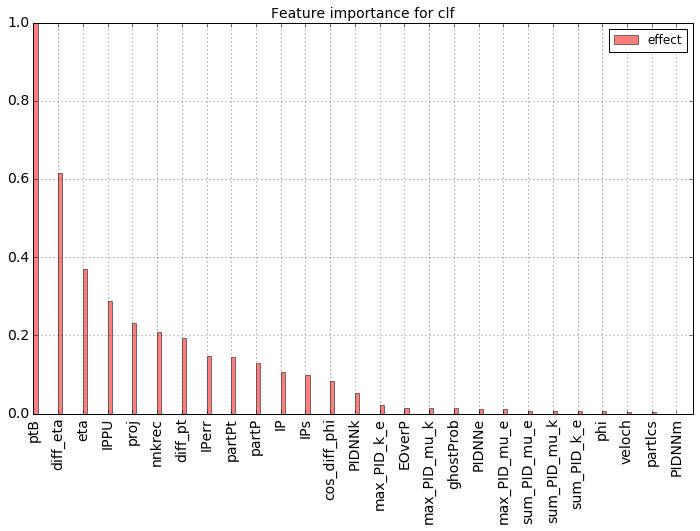

In [24]:
r.feature_importance()

In [25]:
pandas.DataFrame({'names': report.keys(), 'roc: K vs K*': report.values()})

,names,roc: K vs K*
0,"electron, old tagging features",0.583853
1,"electron, all current features",0.581127
2,"muon, old tagging features",0.588851
3,"muon, all current features",0.587806
4,"kaon, old tagging features",0.588717
5,"kaon, all current features",0.589654
6,"all particles, old tagging features",0.588944
7,"all particles, all current features",0.591382
8,"all tracks, inclusive tagging features",0.594309
9,all tracks wo diff_eta,0.590935


In [26]:
probs_test = selected_tt['all tracks, inclusive tagging features'].predict_proba(data)[:, 1]
probs_k = probs_test[data.label.values == 0]
probs_ks = probs_test[data.label.values == 1]

KFold prediction using folds column


In [28]:
probs_k

array([ 0.32738537,  0.33090243,  0.33465943, ...,  0.37075892,
        0.37119889,  0.36918554])

In [35]:
ids_k = numpy.unique(data_k.loc[numpy.isfinite(data_k.IPs), 'event_id'], return_inverse=True)[1]
ids_ks = numpy.unique(data_ks.loc[numpy.isfinite(data_ks.IPs), 'event_id'], return_inverse=True)[1]

In [36]:
len(probs_k), len(ids_k)

(32808324, 32808324)

In [38]:
from scipy.special import logit
new_probs_k = numpy.bincount(ids_k, weights=logit(probs_k))
new_probs_ks = numpy.bincount(ids_ks, weights=logit(probs_ks))

In [ ]:
сумма вероятностей

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score([0] * len(new_probs_k) + [1] * len(new_probs_ks), numpy.concatenate([new_probs_k, new_probs_ks]))

0.55117149948188926

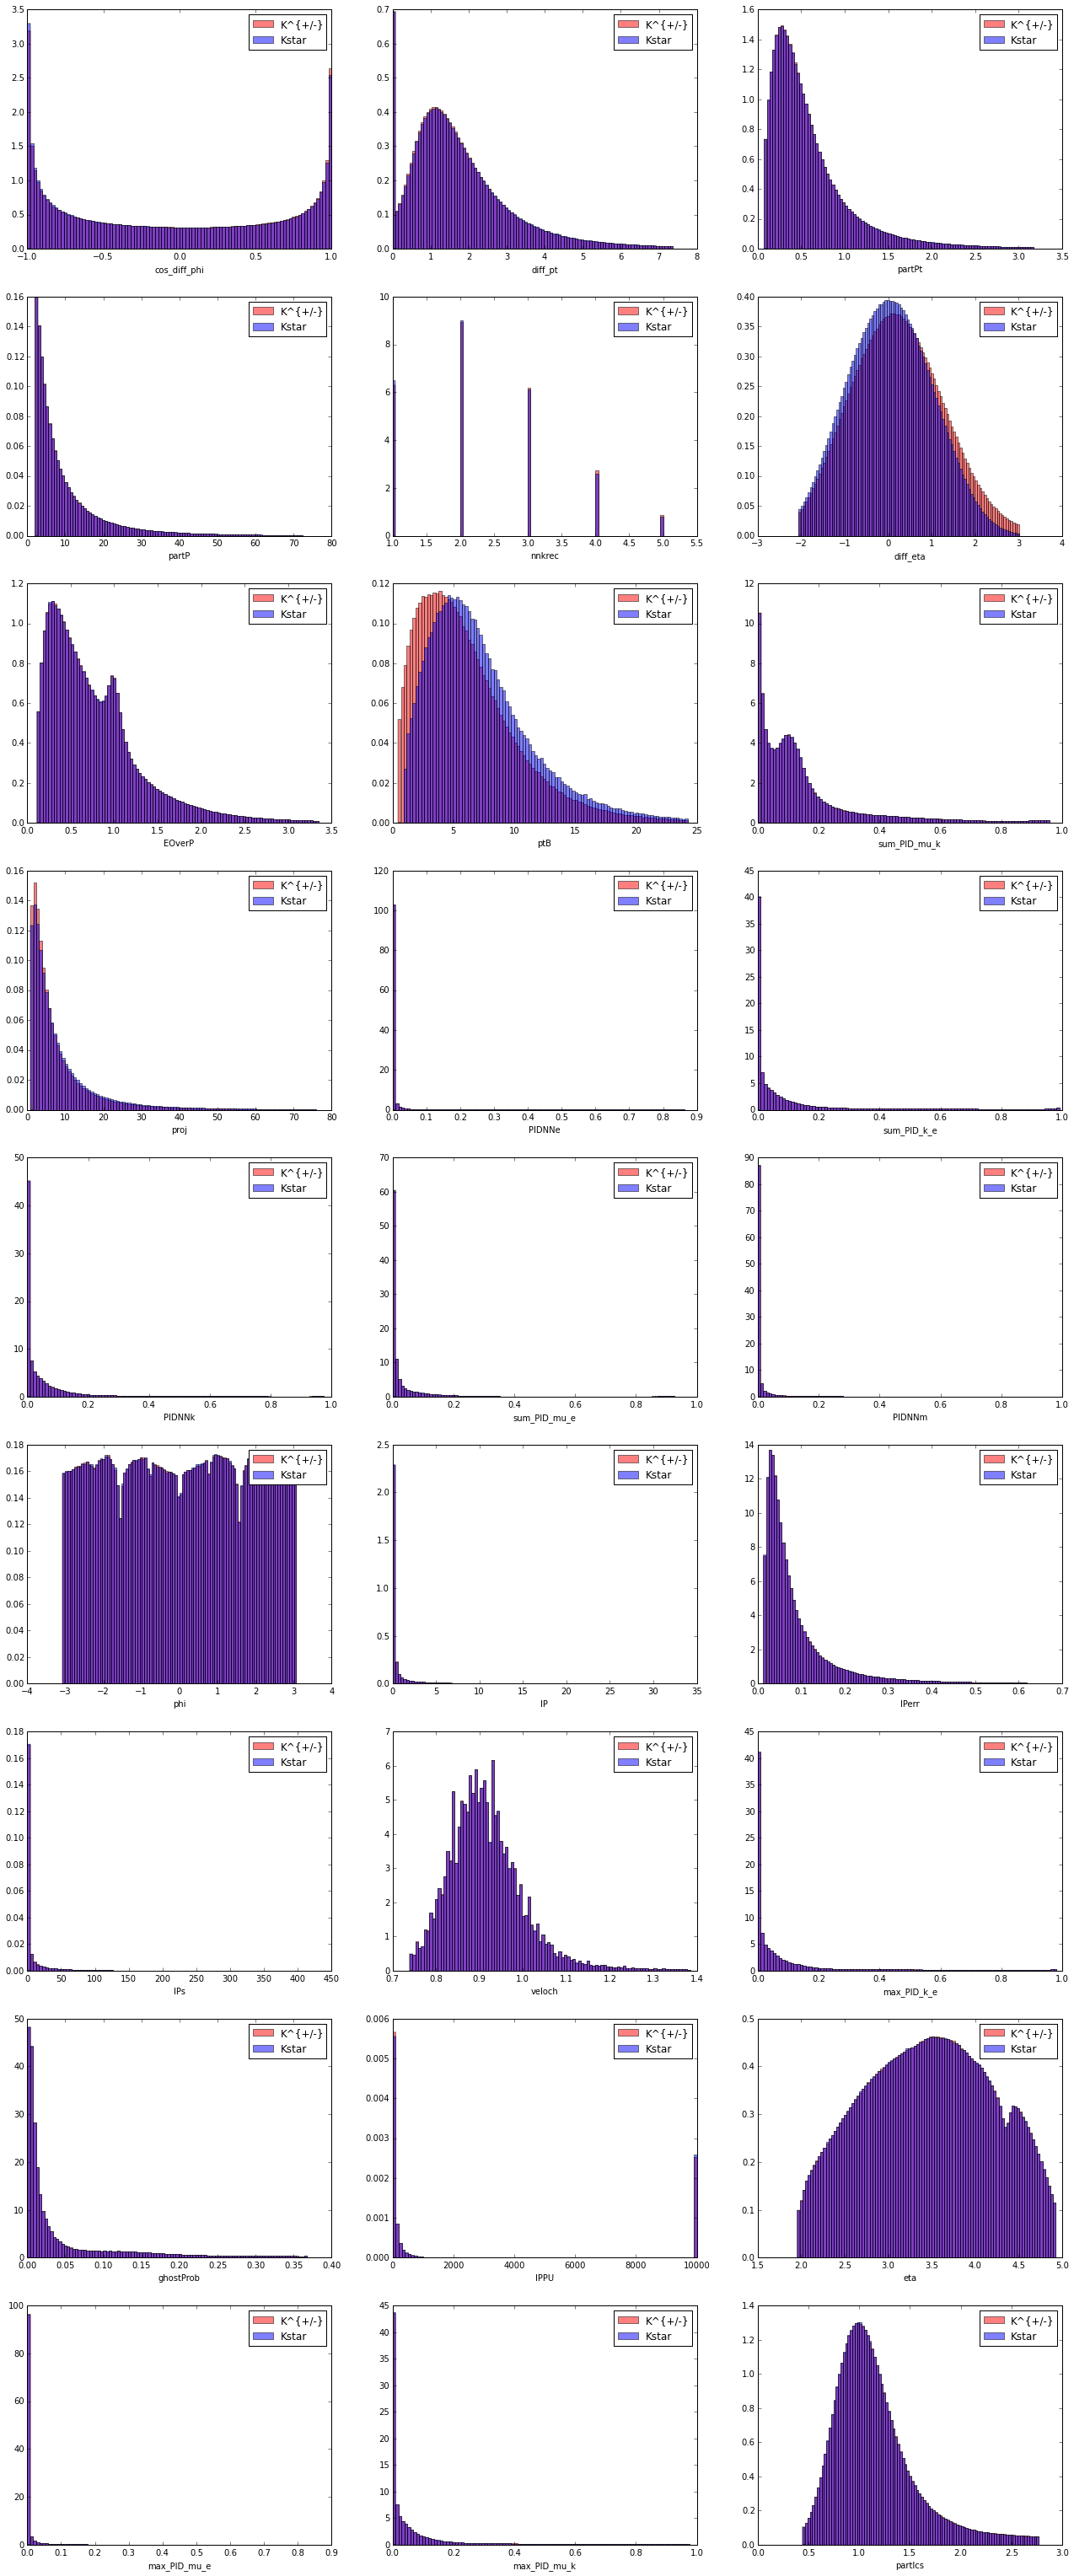

In [26]:
figure(figsize=(22, 60))
for n, f in enumerate(features):
    plt.subplot(10, 3, n + 1)
    x1 = data.ix[data.label == 0, f].values
    x2 = data.ix[data.label == 1, f].values
    mask1 = x1 > -400
    mask2 = x2 > -400
    
    r1 = numpy.percentile(x1[mask1], [1, 99])
    r2 = numpy.percentile(x2[mask2], [1, 99])
    r = (min(r1[0], r2[0]), max(r1[1], r2[1]))
    hist(x1[mask1], normed=True, alpha=0.5, bins=100, range=r, label='K^{+/-}')
    hist(x2[mask2], normed=True, alpha=0.5, bins=100, range=r, label='Kstar')
    xlabel(f)
    legend()